In [ ]:
# Import necessary libraries for data manipulation, modeling, and visualization
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For creating visualizations
from sklearn.ensemble import RandomForestRegressor  # For Random Forest modeling
from xgboost import XGBRegressor  # For XGBoost modeling
import time  # For tracking execution time
import os  # For handling file paths

# Ensures that plots are rendered within the Jupyter Notebook
%matplotlib inline

# ================================
# Data Loading Functions
# ================================

In [2]:
def load_data(dataset, reynolds_num, data_type='train'):
    """
    Loads feature and target data for training or testing.

    Parameters:
    - dataset (str): Name of the dataset (e.g., 'pehill').
    - reynolds_num (str): Reynolds number identifier (e.g., 'Re5600').
    - data_type (str): Type of data to load ('train' or 'test').

    Returns:
    - features (ndarray): Loaded feature data.
    - targets (ndarray): Loaded target response data.
    """
    # Define base paths
    base_path = f'./database/{dataset}/'

    if data_type == 'train':
        markers_path = f'{base_path}/markers/{reynolds_num}/markerFile'
        delta_fields_path = f'{base_path}/deltaFields/{reynolds_num}/deltaField'
    elif data_type == 'test':
        markers_path = f'{base_path}/markers/{reynolds_num}/markerFile'
        delta_fields_path = f'{base_path}/deltaFields/{reynolds_num}/deltaField'
    else:
        raise ValueError("data_type must be either 'train' or 'test'.")

    # Load data from text files
    features = np.loadtxt(markers_path)
    targets = np.loadtxt(delta_fields_path)

    return features, targets

In [3]:
def load_rans_coordinates(dataset, reynolds_num, total_points=971):
    """
    Loads all RANS (Reynolds-Averaged Navier-Stokes) coordinates from multiple files.

    Parameters:
    - dataset (str): Name of the dataset (e.g., 'pehill').
    - reynolds_num (str): Reynolds number identifier (e.g., 'Re10595').
    - total_points (int): Total number of RANS coordinates expected.

    Returns:
    - all_rans_coords (ndarray): Concatenated array of all RANS coordinates.
    """
    # Define the directory containing RANS coordinate files
    rans_dir = f'./database/{dataset}/XiEta-RANS/{reynolds_num}/'

    # Initialize a list to store coordinates from each line
    rans_coords_list = []

    # List all files in the RANS directory that match the pattern 'lineX_XiEta.xy'
    line_files = [f for f in os.listdir(rans_dir) if f.startswith('line') and f.endswith('_XiEta.xy')]
    line_files_sorted = sorted(line_files, key=lambda x: int(x.replace('line','').split('_')[0]))

    # Iterate over each line file and load the coordinates
    for file in line_files_sorted:
        file_path = os.path.join(rans_dir, file)
        line_coords = np.loadtxt(file_path)
        rans_coords_list.append(line_coords)

    # Concatenate all coordinates into a single array
    all_rans_coords = np.vstack(rans_coords_list)

    # Verify the total number of points
    if all_rans_coords.shape[0] != total_points:
        print(f"Warning: Expected {total_points} RANS coordinates, but found {all_rans_coords.shape[0]}.")

    return all_rans_coords

# ================================
# Model Training Functions
# ================================

In [4]:
def train_xgboost(train_X, train_y, params=None):
    """
    Trains an XGBoost regressor with specified hyperparameters.

    Parameters:
    - train_X (ndarray): Training input features.
    - train_y (ndarray): Training target responses.
    - params (dict): Hyperparameters for the XGBoost model.

    Returns:
    - model (XGBRegressor): Trained XGBoost model.
    """
    if params is None:
        params = {
            'n_estimators': 100,
            'max_depth': 3,
            'learning_rate': 0.1,
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'objective': 'reg:squarederror',
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0
        }

    # Initialize and train the XGBoost regressor
    model = XGBRegressor(**params)
    model.fit(train_X, train_y)

    return model

In [5]:
def train_random_forest(train_X, train_y, params=None):
    """
    Trains a Random Forest regressor with specified hyperparameters.

    Parameters:
    - train_X (ndarray): Training input features.
    - train_y (ndarray): Training target responses.
    - params (dict): Hyperparameters for the Random Forest model.

    Returns:
    - model (RandomForestRegressor): Trained Random Forest model.
    """
    if params is None:
        params = {
            'n_estimators': 100,
            'max_depth': None,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'random_state': 42,
            'n_jobs': -1
        }

    # Initialize and train the Random Forest regressor
    model = RandomForestRegressor(**params)
    model.fit(train_X, train_y)

    return model

# ================================
# Prediction Function
# ================================

In [6]:
def make_predictions(model, test_X):
    """
    Generates predictions using the trained model on test data.

    Parameters:
    - model: Trained regression model (XGBoost or Random Forest).
    - test_X (ndarray): Testing input features.

    Returns:
    - predictions (ndarray): Predicted target responses.
    """
    return model.predict(test_X)

# ================================
# Visualization Functions
# ================================

In [7]:
def plot_barycentric(XiEta_RANS, DNS_responses, ML_predictions, title, marker_style='r^'):
    """
    Plots the Reynolds stress anisotropy in the Barycentric triangle for a specific sample line.

    Parameters:
    - XiEta_RANS (ndarray): RANS coordinates for the sample line.
    - DNS_responses (ndarray): DNS target responses for the sample line.
    - ML_predictions (ndarray): ML model predictions for the sample line.
    - title (str): Label for the ML model (e.g., 'XGBoost', 'Random Forest').
    - marker_style (str): Marker style for the ML predictions.
    """
    # Calculate DNS and ML coordinates by adding responses to RANS coordinates
    XiEta_DNS = XiEta_RANS + DNS_responses
    XiEta_ML = XiEta_RANS + ML_predictions

    # Define plotting interval to reduce the number of points plotted
    interval = 2  # Plot every 2nd point
    points_num = XiEta_RANS.shape[0]

    # Initialize the plot
    plt.figure(figsize=(8, 6))

    # Plot the Barycentric triangle boundaries
    plt.plot([0, 1, 0.5, 0.5, 0],
             [0, 0, np.sqrt(3)/2, np.sqrt(3)/2, 0],
             'g-', label='Barycentric Triangle')

    # Plot RANS data points
    plt.plot(XiEta_RANS[::interval, 0], XiEta_RANS[::interval, 1],
             'bo', markerfacecolor='none', markeredgecolor='b',
             markeredgewidth=2, markersize=10, label='RANS')

    # Plot DNS data points
    plt.plot(XiEta_DNS[::interval, 0], XiEta_DNS[::interval, 1],
             'ks', markerfacecolor='none', markeredgecolor='k',
             markeredgewidth=2, markersize=10, label='DNS')

    # Plot ML model predictions
    plt.plot(XiEta_ML[::interval, 0], XiEta_ML[::interval, 1],
             marker_style, markerfacecolor='none',
             markeredgewidth=2, markersize=10, label=title)

    # Configure legend and aesthetics
    plt.legend(loc='upper right')
    plt.ylim([0, np.sqrt(3)/2])
    plt.title('Reynolds Stress Anisotropy in Barycentric Triangle')
    plt.xlabel('Xi Coordinate')
    plt.ylabel('Eta Coordinate')
    plt.grid(True)
    plt.show()

In [8]:
def compare_models_plot(XiEta_RANS, DNS_responses, XGB_predictions, RF_predictions):
    """
    Compares XGBoost and Random Forest predictions in a single plot for a specific sample line.

    Parameters:
    - XiEta_RANS (ndarray): RANS coordinates for the sample line.
    - DNS_responses (ndarray): DNS target responses for the sample line.
    - XGB_predictions (ndarray): XGBoost model predictions for the sample line.
    - RF_predictions (ndarray): Random Forest model predictions for the sample line.
    """
    # Calculate DNS, XGBoost, and Random Forest coordinates by adding responses to RANS coordinates
    XiEta_DNS = XiEta_RANS + DNS_responses
    XiEta_XGB = XiEta_RANS + XGB_predictions
    XiEta_RF = XiEta_RANS + RF_predictions

    # Define plotting interval to reduce the number of points plotted
    interval = 2  # Plot every 2nd point
    points_num = XiEta_RANS.shape[0]

    # Initialize the plot
    plt.figure(figsize=(8, 6))

    # Plot the Barycentric triangle boundaries
    plt.plot([0, 1, 0.5, 0.5, 0],
             [0, 0, np.sqrt(3)/2, np.sqrt(3)/2, 0],
             'g-', label='Barycentric Triangle')

    # Plot RANS data points
    plt.plot(XiEta_RANS[::interval, 0], XiEta_RANS[::interval, 1],
             'bo', markerfacecolor='none', markeredgecolor='b',
             markeredgewidth=1.5, markersize=8, label='RANS')

    # Plot DNS data points
    plt.plot(XiEta_DNS[::interval, 0], XiEta_DNS[::interval, 1],
             'ks', markerfacecolor='none', markeredgecolor='k',
             markeredgewidth=1.5, markersize=8, label='DNS')

    # Plot XGBoost predictions
    plt.plot(XiEta_XGB[::interval, 0], XiEta_XGB[::interval, 1],
             'r^', markerfacecolor='none', markeredgecolor='r',
             markeredgewidth=1.5, markersize=8, label='XGBoost')

    # Plot Random Forest predictions
    plt.plot(XiEta_RF[::interval, 0], XiEta_RF[::interval, 1],
             'g+', markerfacecolor='none', markeredgecolor='g',
             markeredgewidth=1.5, markersize=8, label='Random Forest')

    # Configure legend and aesthetics
    plt.legend(loc='upper right')
    plt.ylim([0, np.sqrt(3)/2])
    plt.title('Comparison of XGBoost and Random Forest Predictions')
    plt.xlabel('Xi Coordinate')
    plt.ylabel('Eta Coordinate')
    plt.grid(True)
    plt.show()

# ================================
# Utility Functions
# ================================

In [9]:
def plot_execution_times(xgb_time, rf_time):
    """
    Plots a bar chart comparing the CPU execution times of XGBoost and Random Forest models.

    Parameters:
    - xgb_time (float): Execution time for the XGBoost model in seconds.
    - rf_time (float): Execution time for the Random Forest model in seconds.
    """
    # Define labels and corresponding execution times
    labels = ['XGBoost', 'Random Forest']
    times = [xgb_time, rf_time]

    # Set the position of the bars on the x-axis
    x_positions = np.arange(len(labels))

    # Create the bar chart
    plt.figure(figsize=(6, 6))
    plt.bar(x_positions, times, width=0.4, color=['skyblue', 'salmon'])

    # Labeling the axes and setting title
    plt.ylabel('CPU Time (seconds)', fontsize=12)
    plt.title('Model Training Times', fontsize=14)

    # Setting the position and labels of the x-ticks
    plt.xticks(x_positions, labels)

    # Annotate bars with their respective heights
    for idx, time_val in enumerate(times):
        plt.text(x_positions[idx], time_val + 0.5, f"{time_val:.2f}", ha='center', va='bottom')

    # Display the plot
    plt.show()

In [10]:
def iterate_and_plot(dataset, reynolds_num, test_targets, xgb_preds, rf_preds, lines_to_plot=[3,5]):
    """
    Iterates over specified sample lines and generates Barycentric coordinate plots.

    Parameters:
    - dataset (str): Name of the dataset (e.g., 'pehill').
    - reynolds_num (str): Reynolds number identifier (e.g., 'Re10595').
    - test_targets (ndarray): Actual DNS target responses for the test data.
    - xgb_preds (ndarray): XGBoost model predictions for the test data.
    - rf_preds (ndarray): Random Forest model predictions for the test data.
    - lines_to_plot (list): List of line numbers to plot (e.g., [3,5]).
    """
    # Define the starting indices for different sample lines
    sample_indices = [0, 98, 191, 287, 385, 483, 581, 679, 777, 875, 971]

    # Directory containing RANS coordinate files
    rans_dir = f'./database/{dataset}/XiEta-RANS/{reynolds_num}/'

    # Iterate over the specified sample lines
    for line_num in lines_to_plot:
        # Construct the file path for the current line's RANS coordinates
        rans_file = f'line{line_num}_XiEta.xy'
        rans_path = os.path.join(rans_dir, rans_file)

        # Load RANS coordinates for the current line
        XiEta_RANS = np.loadtxt(rans_path)

        # Determine the range of indices for the current line
        start_idx = sample_indices[line_num - 1]
        end_idx = sample_indices[line_num]

        # Extract actual DNS responses and model predictions for the current line
        DNS_responses = test_targets[start_idx:end_idx, :]
        XGB_predictions = xgb_preds[start_idx:end_idx, :]
        RF_predictions = rf_preds[start_idx:end_idx, :]

        # Generate individual plots for XGBoost and Random Forest
        plot_barycentric(XiEta_RANS, DNS_responses, XGB_predictions, title='XGBoost', marker_style='r^')
        plot_barycentric(XiEta_RANS, DNS_responses, RF_predictions, title='Random Forest', marker_style='g+')

        # Generate a combined comparison plot for both models
        compare_models_plot(XiEta_RANS, DNS_responses, XGB_predictions, RF_predictions)

# ================================
# Main Execution Workflow
# ================================

In [11]:
# Step 1: Data Loading
# Specify dataset name and Reynolds numbers for training and testing
dataset = 'pehill'
training_reynolds = 'Re5600'
testing_reynolds = 'Re10595'

# Load training data
train_features, train_targets = load_data(dataset, training_reynolds, data_type='train')

# Load testing data
test_features, test_targets = load_data(dataset, testing_reynolds, data_type='test')

# Load all RANS coordinates for the test set
all_rans_coords = load_rans_coordinates(dataset, testing_reynolds, total_points=971)

# Verify the shape of loaded RANS coordinates
print(f"Loaded RANS coordinates shape: {all_rans_coords.shape}")  # Expected: (971, 2)

Loaded RANS coordinates shape: (971, 2)


In [12]:
# Step 2: Model Training and Prediction
# Define hyperparameters for XGBoost and Random Forest
xgb_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

rf_params = {
    'n_estimators': 200,
    'max_depth': 10,  # Example value; can be tuned
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42,
    'n_jobs': -1
}

# Train XGBoost model and record training time
start_time_xgb = time.time()
xgb_model = train_xgboost(train_features, train_targets, params=xgb_params)
end_time_xgb = time.time()
xgb_training_time = end_time_xgb - start_time_xgb
print(f"XGBoost model trained in {xgb_training_time:.2f} seconds.")

# Generate predictions using the trained XGBoost model
xgb_predictions = make_predictions(xgb_model, test_features)

# Train Random Forest model and record training time
start_time_rf = time.time()
rf_model = train_random_forest(train_features, train_targets, params=rf_params)
end_time_rf = time.time()
rf_training_time = end_time_rf - start_time_rf
print(f"Random Forest model trained in {rf_training_time:.2f} seconds.")

# Generate predictions using the trained Random Forest model
rf_predictions = make_predictions(rf_model, test_features)


XGBoost model trained in 0.58 seconds.
Random Forest model trained in 0.71 seconds.


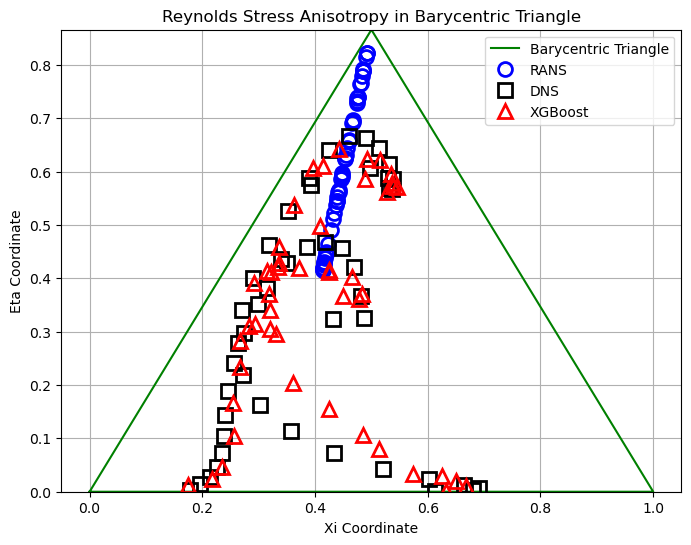

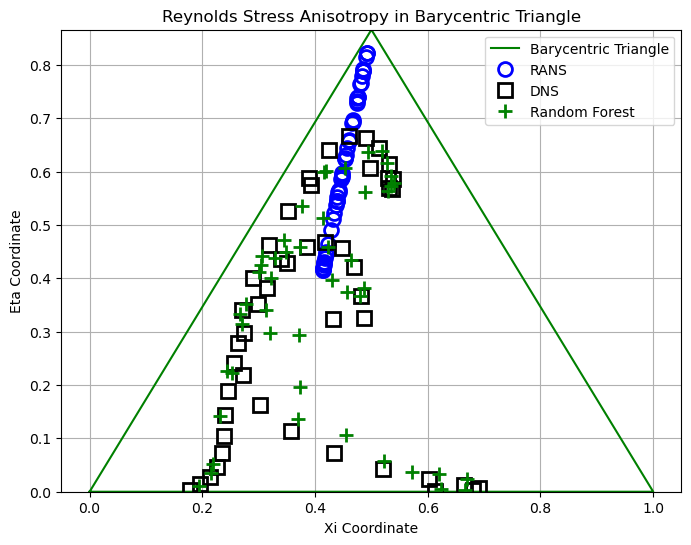

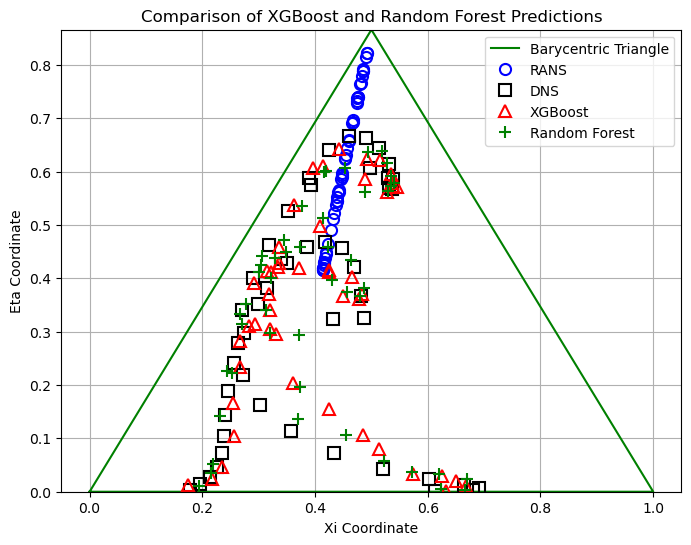

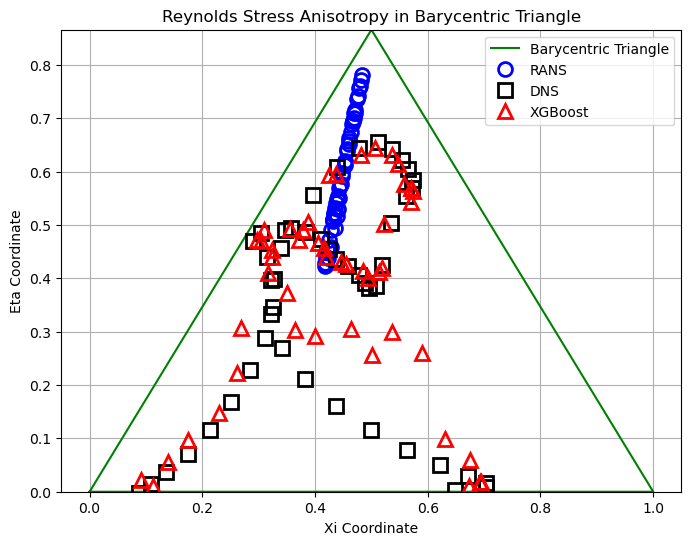

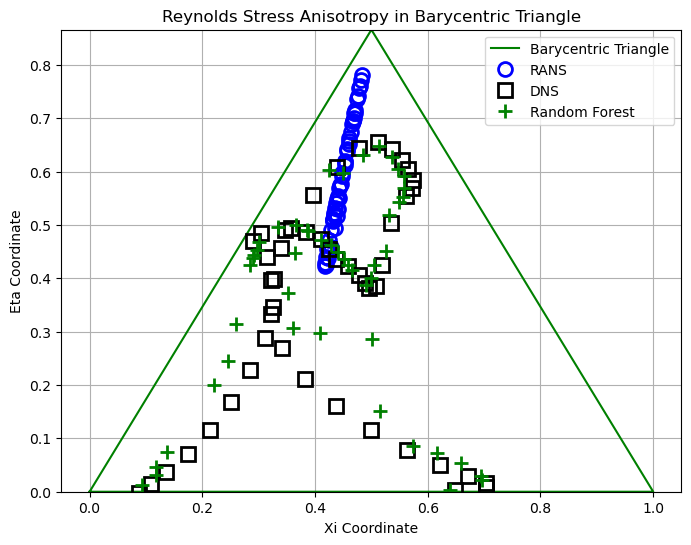

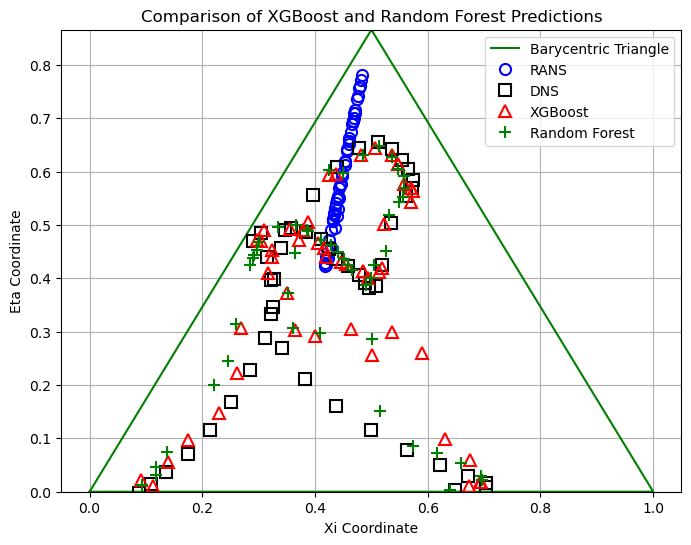

In [13]:
# Step 3: Visualization
# Specify which sample lines to plot (similar to original code)
sample_lines = [3, 5]

# Iterate over sample lines and generate plots
iterate_and_plot(dataset, testing_reynolds, test_targets, xgb_predictions, rf_predictions, lines_to_plot=sample_lines)

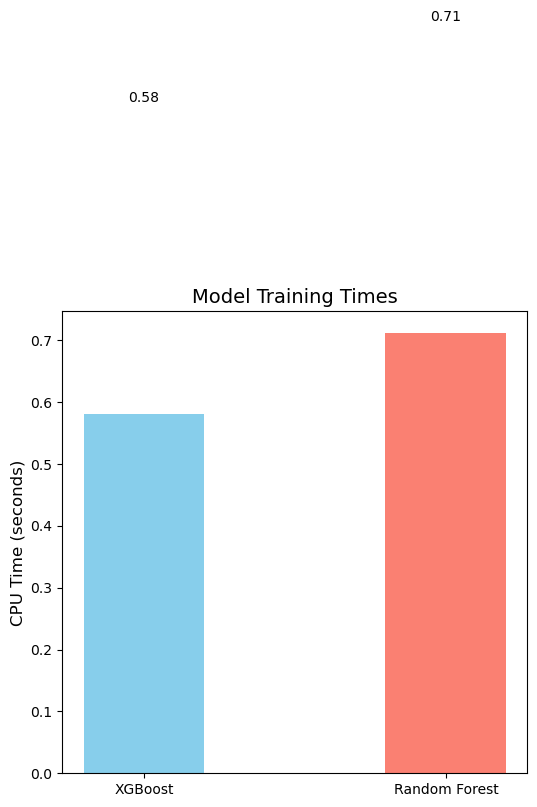

In [14]:
# Step 4: Performance Comparison
# Plot the execution times of both models
plot_execution_times(xgb_training_time, rf_training_time)